In [3]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import math
import random
import time
import os
import pickle

import xml.etree.ElementTree as ET



import tensorflow as tf

In [4]:
!curl -o strokes_training_data.cpkl https://raw.githubusercontent.com/greydanus/scribe/master/data/strokes_training_data.cpkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44.3M  100 44.3M    0     0  42.9M      0  0:00:01  0:00:01 --:--:-- 42.9M


In [16]:
with open("strokes_training_data.cpkl","rb") as f:
  # print(f.read())
  temp = pickle.load(f,encoding="bytes")

In [21]:
print(temp[0][1])

[[331 253   0]
 [ -2   4   0]
 [ -8   9   0]
 ...
 [ 14  -5   0]
 [  9  -4   0]
 [ 11  -3   1]]


In [8]:
!tar -xvf ascii.tgz

./
forms.txt
lines.txt
words.txt
sentences.txt


In [ ]:
!cat

In [29]:
class DataLoader():
  def __init__(self,batch_size= 50,tsteps = 300,scale_factor=10,U_items = 10,limit = 500 ,alphabet='default',data="strokes_training_data.cpkl"):
    self.alphabet = alphabet
    self.batch_size = batch_size
    self.tsteps = tsteps
    self.scale_factor = scale_factor
    self.limit = limit
    self.U_items = U_items

    with open(data,"rb") as f:
      self.raw_stroke_data,self.raw_ascii_data = pickle.load(f,encoding="bytes")
    self.load_preprocessed()
    


    self.reset_batch_pointer()
  def load_preprocessed(self):
    self.stroke_data = []
    self.ascii_data = []
    counter = 0

    for i in range(len(self.raw_stroke_data)):
        data = self.raw_stroke_data[i]
        if len(data) > (self.tsteps+2):
            # removes large gaps from the data
            data = np.minimum(data, self.limit)
            data = np.maximum(data, -self.limit)
            data = np.array(data,dtype=np.float32)
            data[:,0:2] /= self.scale_factor
            
            self.stroke_data.append(data)
            self.ascii_data.append(self.raw_ascii_data[i])

    # minus 1, since we want the ydata to be a shifted version of x data
    self.num_batches = int(len(self.stroke_data) / self.batch_size)

    print("Loaded dataset")
  def reset_batch_pointer(self):
    self.idx_perm = np.random.permutation(len(self.stroke_data))
    self.pointer = 0

  def tick_batch_pointer(self):
    self.pointer +=1 
    if(self.pointer >=len(self.stroke_data)):
      self.reset_batch_pointer()
  
  def next_batch(self):
    x_batch = []
    y_batch = []
    ascii_list = []
    for i in range(self.batch_size):
        data = self.stroke_data[self.idx_perm[self.pointer]]
        x_batch.append(np.copy(data[:self.tsteps]))
        y_batch.append(np.copy(data[1:self.tsteps+1]))
        ascii_list.append(self.ascii_data[self.idx_perm[self.pointer]])
        self.tick_batch_pointer()
    one_hots = [self.one_hot(s) for s in ascii_list]
    return x_batch, y_batch, ascii_list, one_hots

  def one_hot(self, s):
    if self.alphabet is "default":
        alphabet = " abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890"
    # print(s)
    seq = [alphabet.find(char) + 1 for char in str(s)]
    if len(seq) >= self.U_items:
        seq = seq[:self.U_items]
    else:
        seq = seq + [0]*(self.U_items - len(seq))
    one_hot = np.zeros((self.U_items,len(alphabet)+1))
    one_hot[np.arange(self.U_items),seq] = 1
    return one_hot

In [30]:
data_loader = DataLoader(batch_size=5, tsteps = 700, scale_factor = 50,U_items = int(700/20))

Loaded dataset


In [35]:
def line_plot(strokes, title):
    plt.figure(figsize=(20,2))
    eos_preds = np.where(strokes[:,-1] == 1)
    eos_preds = [0] + list(eos_preds[0]) + [-1] #add start and end indices
    for i in range(len(eos_preds)-1):
        start = eos_preds[i]+1
        stop = eos_preds[i+1]
        plt.plot(strokes[start:stop,0], strokes[start:stop,1])
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

15


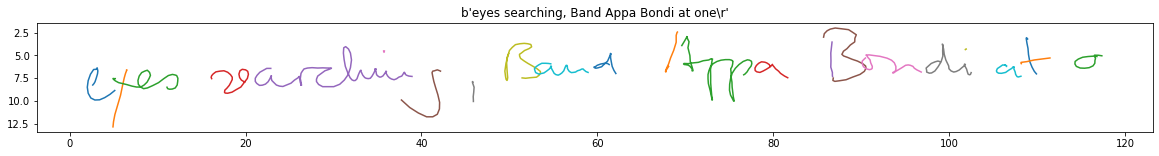

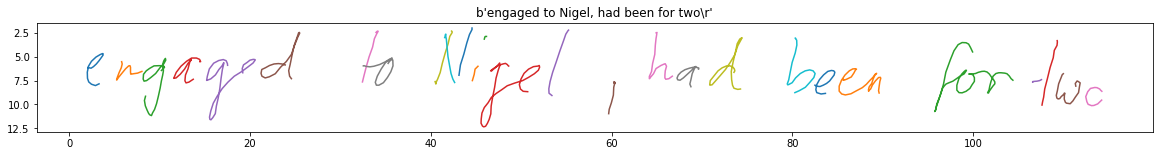

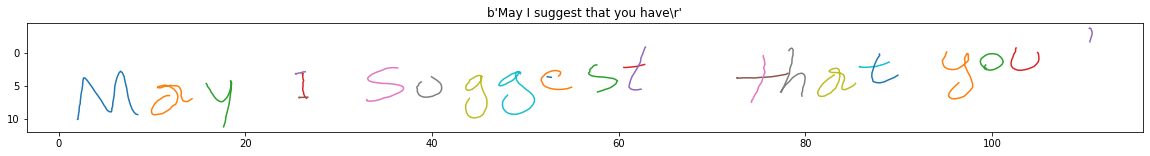

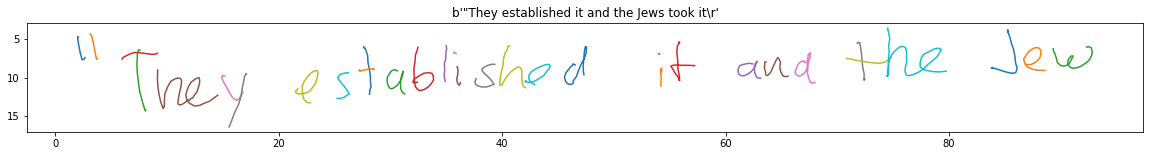

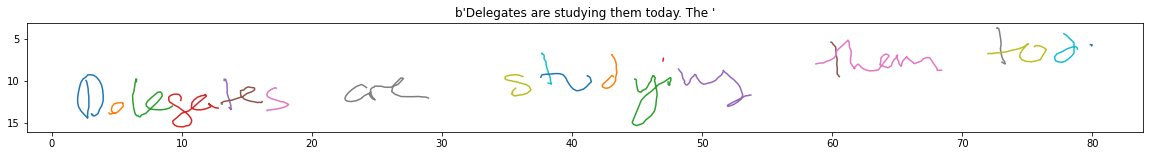

In [36]:
x, y, s, c = data_loader.next_batch()
print(data_loader.pointer)
for i in range(5):
    r = x[i]
    strokes = r.copy()
    strokes[:,:-1] = np.cumsum(r[:,:-1], axis=0)
    line_plot(strokes, s[i][:45])

In [ ]:
args = dict()
args["alphabet"]=' abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
args["text"] = 'A project by Biswajit Patra'
args["rnn_size"] =100
args["train"] = False
args["tsteps"] = 256 if args["train"] else 1









In [ ]:
class my_model():
  def __init__(self,alphabet,text,rnn_size,train,tsteps):
    
    self.char_vec_len = len(alphabet) + 1
    self.alphabets = alphabet 
    self.graves_init = tf.initializers.TruncatedNormal(mean=0., stddev=.075, seed=None)
    self.window_b_init = tf.initializers.TruncatedNormal(mean=-3.0,stddev=.25,seed=None)

    self.rnn_cell = tf.keras.layers.LSTMCell
    self.cell0 = self.rnn_cell(rnn_size)
    self.cell1 = self.rnn_cell(rnn_size)
    self.cell2 = self.rnn_cell(rnn_size) 

    self.input_data = tf.placeholder(dtype=tf.float32, shape=[None,tsteps,3])
    self.target_data = tf.placeholder(dtype= tf.dtype32, shape = [None,tsteps,3])
    

model = my_model(**args)

# model.graves_init = tf.random.truncated_normal(mean=0., stddev=.075, seed=None)
# print(model.graves_init)


AttributeError: ignored

In [ ]:
trial=tf.initializers.TruncatedNormal(
    mean=0.0, stddev=1.0, seed=None
)
trial